# Supervised Learning for HR Separations
## July 1, 2015
<hr>

### 1. Return to the ETL to correct the dataset 
* (no longer do I need to labelEncode GRADE)
* use bear
#### define the source repo
* '/home/kesj/lib/repo/'

### 2. Define the correct working directories
* '/data/discovery/hrsepara/core/' for HDFS
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')


In [3]:
os.chdir(repodir)
import bear.bear as br

In [4]:
os.chdir(stgdir1local)

# so try to reload employee data and parse using BEAR?
* first load things that won't change like the economic data

## Import the unemployment measure into a DataFrame

In [5]:
### load in the federal unemployment data
unempl_raw = pd.read_csv('us_unemployment_monthly_seas.csv')
unempl_raw.head()
### convert to useable format
unempl = pd.melt(unempl_raw, id_vars='Year')
unempl.sort('Year', inplace=True)
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
unempl.head()

,Year,variable,value,date
0,1987,Jan,6.6,1987-01-01
29,1987,Feb,6.6,1987-02-01
58,1987,Mar,6.6,1987-03-01
87,1987,Apr,6.3,1987-04-01
116,1987,May,6.3,1987-05-01


In [6]:
unempl.set_index('date',inplace=True)

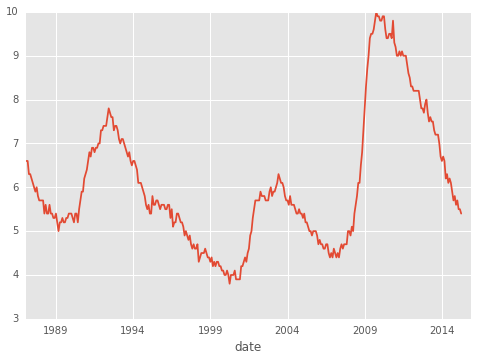

In [7]:
#plt.plot(unempl.date,unempl.value,'d--',color='limegreen')
unempl['value'].plot()

## helper functions follow

In [8]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.index <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

In [9]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [10]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

## Load un-filled file and try using BEAR
'employee_dataframe.tsv'

In [11]:
datafile = 'employee_dataframe.ssv'
emplraw = pd.read_csv(datafile,sep=';',dtype={'KEY':np.str})
print emplraw.shape
emplraw.drop('Unnamed: 0',axis=1,inplace=True)

(243010, 185)


In [12]:
br.printall(emplraw)

,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,ADDRCNT1,ADDRCNT10,ADDRCNT3,ADDRCNT5,ADDRESS1,ADDRESS2,ANNUAL_RT,Age_tdelta,Age_years,BIRTHDATE,BOX1,BOX10,BOX2,BOX3,BOX4,BOX5,BOX6,BOX7,BOX8,BOX9,COMPANY,COMP_FREQUENCY,CUR_DEPT_MOS,CUR_EFUNC_MOS,CUR_FUNC_MOS,CUR_GRADE_MOS,CUR_JOB_MOS,CUR_LOC_MOS,DEPTCNT1,DEPTCNT10,DEPTCNT3,DEPTCNT5,DIRECT_RPT_CNT,DIVISION_CODE_SFI,EEO1CODE,EFUNCCNT1,EFUNCCNT10,EFUNCCNT3,EFUNCCNT5,EMPL_CLASS,EMPL_TYPE,ETHNIC_GROUP,EXTFUNC_CNT,EXT_FUNC_ID_SFI,FLOORCNT1,FLOORCNT10,FLOORCNT3,FLOORCNT5,FLOR_SFI,FLSA_STATUS,FTE,FTPTCNT1,FTPTCNT10,FTPTCNT3,FTPTCNT5,FULLPART1,FULLPART10,FULLPART3,FULLPART5,FULL_PART_TIME,FUNCCNT1,FUNCCNT10,FUNCCNT3,FUNCCNT5,FUNC_CNT,FUNC_ID_SFI,GRADE,GRADECNT1,GRADECNT10,GRADECNT3,GRADECNT5,HIRE_DT,HUBIND,INTERN,JOBCNT1,JOBCNT10,JOBCNT3,JOBCNT5,JOBCODE,JOB_FAMILY,JOB_FUNCTION,KEY,LAST_HIRE_DT,LEGACY_DEPT_SFI,LOCATION,LOCCNT1,LOCCNT10,LOCCNT3,LOCCNT5,LOCSTCNT1,LOCSTCNT10,LOCSTCNT3,LOCSTCNT5,LOC_CITY,LOC_STATE,LOC_TYPE_DESCR_SFI,MAR_STATUS_DT,MAR_STA_SNAME_SFI,MAX_RT_ANNUAL,MERIT1,MERIT10,MERIT2,MERIT3,MERIT4,MERIT5,MERIT6,MERIT7,MERIT8,MERIT9,MIN_RT_ANNUAL,PARTFULL1,PARTFULL10,PARTFULL3,PARTFULL5,PERF1,PERF10,PERF2,PERF3,PERF4,PERF5,PERF6,PERF7,PERF8,PERF9,PER_ORG,POSTAL_SFI,PTFTCNT1,PTFTCNT10,PTFTCNT3,PTFTCNT5,RATE1,RATE10,RATE2,RATE3,RATE4,RATE5,RATE6,RATE7,RATE8,RATE9,REH_CNT,RELOCATE_ALL_SFI,RELO_STATE_CNT_SFI,REMOTE,REMOTE_SUPV,SAL1,SAL10,SAL2,SAL3,SAL4,SAL5,SAL6,SAL7,SAL8,SAL9,SERVICE_DT,SEX,SHIFT,SKEY,STATE,STD_HOURS,SUPVCNT1,SUPVCNT10,SUPVCNT3,SUPVCNT5,SUPV_DIFF_LOC,TELE_MOS,TERMINATION_DT,TOTAL_RPT_CNT,TOT_MO_SERVICE_SFI,Tenure_months,Tenure_tdelta,VOLINVOL,status
0,DECEMBER NEW HIRE;RRTR W/O JOB NUMBER CHANGE;B...,NaN,EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,0,6506 MOJAVE ST NW,NaN,68301.00,"14904 days, 00:00:00",40.805766,1968-10-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,A,7.000000,7.258065,7.258065,7.258065,7.258065,7.000000,1,1,1,1,63,9,4,0,0,0,0,1,E,3,1078,610,0,0,0,0,999,N,1.00,0,0,0,0,N,N,N,N,F,0,0,0,0,5196,9,UNS,0,0,0,0,2008-12-24 00:00:00,N,Y,0,0,0,0,3101,AGYINT,NSA,812163208058180,2008-12-24 00:00:00,124038TB5D4,24TB5,1,1,1,1,1,1,1,1,ALBUQUERQUE,NM,TELEWORKER - MOBILE,24DEC2008,MARRIED,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EMP,87120,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,N,0,Y,N,68301.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-12-24 00:00:00,M,1,4.728472e+14,NM,38.75,0,0,0,0,Y,0,2009-07-31 00:00:00,63,7,7.195220,"219 days, 00:00:00",VOLUNTARY,1
1,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1949 E UNIVERSITY DR. APT.4048,NaN,16099.20,"7788 days, 00:00:00",21.322820,1993-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,H,6.709677,6.709677,6.709677,6.709677,6.709677,6.709677,0,0,0,0,17,9,5,0,0,0,0,1,H,2,1827,71,0,0,0,0,999,N,0.62,0,0,0,0,N,N,N,N,P,0,0,0,0,3846,933,PA1,0,0,0,0,2014-06-09 00:00:00,Y,N,0,0,0,0,6200,RSCREP,PSA,490903510940682,2014-06-09 00:00:00,12400451524,24515,0,0,0,0,0,0,0,0,TEMPE,AZ,OPERATIONS CENTER,09JUN2014,SINGLE,38026.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22400.90,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EMP,85281,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,N,0,N,N,16099.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-06-09 00:00:00,F,1,3.419407e+14,AZ,24.00,3,3,3,3,N,0,2015-01-01 00:00:00,17,7,6.768106,"206 days, 00:00:00",NOT,0
2,MERIT;INCENTIVE;ANOTHER OPPORTUNITY,EMPLOYEE NEW HIRE;MISCELLANEOUS DATA CHANGE;JO...,MERIT;INCENTIVE;MISCELLANEOUS DATA CHANGE,MERIT,PROMOTION;MERIT;RRTR W/JOB NUMBER CHANGE,SALARY PLAN CHANGE;MERIT;MISCELLANEOUS DATA CH...,MERIT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS ...,MERIT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS ...,MISCELLANEOUS DATA CHANGE;MERIT,MISCELLANEOUS DATA CHANGE;MERIT;JOB CODE CHANG...,0,1,0,0,14110 ANGELTON TERR,NaN,58551.95,"12981 days, 00:00:00",35.540771,1976-03-08 00:00:00,S,NaN,H,H,S,S,S,S,L,S,5,A,40

## Step through the DF with bear
1. list all columns
2. find those that have all nulls
3. find those that have any missing

In [13]:
# step through using bear
#1 identify columns with missing values
all_cols = emplraw.columns.tolist()
print [c for c in all_cols]

['ACTRES1', 'ACTRES10', 'ACTRES2', 'ACTRES3', 'ACTRES4', 'ACTRES5', 'ACTRES6', 'ACTRES7', 'ACTRES8', 'ACTRES9', 'ADDRCNT1', 'ADDRCNT10', 'ADDRCNT3', 'ADDRCNT5', 'ADDRESS1', 'ADDRESS2', 'ANNUAL_RT', 'Age_tdelta', 'Age_years', 'BIRTHDATE', 'BOX1', 'BOX10', 'BOX2', 'BOX3', 'BOX4', 'BOX5', 'BOX6', 'BOX7', 'BOX8', 'BOX9', 'COMPANY', 'COMP_FREQUENCY', 'CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS', 'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'DEPTCNT1', 'DEPTCNT10', 'DEPTCNT3', 'DEPTCNT5', 'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI', 'EEO1CODE', 'EFUNCCNT1', 'EFUNCCNT10', 'EFUNCCNT3', 'EFUNCCNT5', 'EMPL_CLASS', 'EMPL_TYPE', 'ETHNIC_GROUP', 'EXTFUNC_CNT', 'EXT_FUNC_ID_SFI', 'FLOORCNT1', 'FLOORCNT10', 'FLOORCNT3', 'FLOORCNT5', 'FLOR_SFI', 'FLSA_STATUS', 'FTE', 'FTPTCNT1', 'FTPTCNT10', 'FTPTCNT3', 'FTPTCNT5', 'FULLPART1', 'FULLPART10', 'FULLPART3', 'FULLPART5', 'FULL_PART_TIME', 'FUNCCNT1', 'FUNCCNT10', 'FUNCCNT3', 'FUNCCNT5', 'FUNC_CNT', 'FUNC_ID_SFI', 'GRADE', 'GRADECNT1', 'GRADECNT10', 'GRADEC

In [14]:
len(emplraw[emplraw.TOT_MO_SERVICE_SFI< 0]) # check that all have positive mos

143

## REmove those that have negative tenure

In [15]:
emplpos = emplraw[emplraw.TOT_MO_SERVICE_SFI>=0].copy()
print np.shape(emplpos)

(242867, 184)


## DROP those that have a grade of UNS

In [16]:
## remove seasonal/interns
print "{0} employees with the GRADE UNS will be dropped.".format((emplpos.GRADE=='UNS').sum())
empl1=emplpos[emplpos.GRADE!='UNS'].copy()

43521 employees with the GRADE UNS will be dropped.


In [17]:
## look for those with Ontario
sum(empl1.LOC_STATE=='ON')#, sum(ret_empl.LOC_STATE == 'ON')

0

In [18]:
# check if any column has all missing
chk_for_null_columns = br.get_columns_with_all_nulls(empl1)
if len(chk_for_null_columns) > 0:
    print "WARNING there are {0} columns that are completely null.".format(chk_for_null_columns)
    print chk_for_null_columns
    empl1.drop(chk_for_null_columns,axis=1,inplace=True)
else:
    print "there were no columns that were universally null."
    


there were no columns that were universally null.


In [19]:
np.shape(empl1)

(199346, 184)

In [20]:
empl1.VOLINVOL.value_counts()

VOLUNTARY      90007
NOT            69806
INVOLUNTARY    38718
UNKNOWN          497
OTHER            318
dtype: int64

## Import and JOIN with BENEFITS info

In [ ]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

In [ ]:
bene_df = pandas_read_hdfs('/data/discovery/hrsepara/core/SR_BENEFIT.txt',dtype_dict={'KEY':np.str})
bene_df.shape

In [ ]:
bene_df.replace({'Y': 1, 'N':0},inplace=True)
bene_df.head()

In [ ]:
# rename 'COUNT               ' 'DEP_COUNT'
bene_df = bene_df.rename(columns={'COUNT               ':'DEP_COUNT'})

In [ ]:
empl_bene = pd.merge(empl1,bene_df,on='KEY',how = 'left')
print np.shape(empl_bene)

# encode some categorical

In [ ]:
## try to deal with location via zipcode
empl_bene['zip5'] = empl_bene['POSTAL_SFI'].apply(lambda(x): truncate_postal_zip(x))
empl_bene.drop('POSTAL_SFI',axis=1,inplace=True)
empl_bene['zip5'].unique()

In [ ]:
#empl_ben
#encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empl_bene['sep_status'] = empl_bene['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
print empl_bene.sep_status.value_counts()
empl_bene.drop('VOLINVOL',axis=1,inplace=True)

In [ ]:
## deal with MAR_STA_SNAME_SFI
empl_bene['mar_status'] = empl_bene['MAR_STA_SNAME_SFI'].replace({'MARRIED':0,'SINGLE':1,'LEG SEPAR':2})
print empl_bene.mar_status.value_counts()
empl_bene.drop('MAR_STA_SNAME_SFI',axis=1,inplace=True)

In [ ]:
# fill missing values in as zeros
empl_bene[bene_df.columns] = empl_bene[bene_df.columns].fillna(0)
empl_bene['DEP_COUNT'].describe()

## Identify Retired

In [ ]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = empl1.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [x.split(';') for x in map(str,uniq_action_reasons_1)]
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
#ret_action_reasons_1 = [x for x in uniq_action_reasons_1 if 'RETIREMENT' in x]
#print len(ret_action_reasons_1)
act_reason_1_set = set(act_reason_1_list)
print len(act_reason_1_set)
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
print len(possible_retire_codes)
possible_retire_codes.sort()
print [c for c in possible_retire_codes]

In [ ]:
def identify_retired(x,ret_codes =possible_retire_codes):
    matched = [a for a in str(x).split(';') if a in ret_codes]
    if len(matched):
        return 1
    else:
        return 0

In [ ]:
empl_bene['retired'] = empl_bene.ACTRES1.apply(lambda x: identify_retired(x))

In [ ]:
empl_bene.retired.value_counts()

In [ ]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.date <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

In [ ]:
unempl.head()

In [ ]:
## assign unemployement_rate
empl_bene['unempl_rate'] = empl_bene.TERMINATION_DT.apply(lambda x: assign_unempl_rate(x,unempl))

In [ ]:
empl_bene.T

In [ ]:
# identify the columns with missing data
cols_with_missing_data = br.get_columns_with_nulls(empl_bene)
if len(cols_with_missing_data)==0:
    print "there were no columns with missing data."
else:
    print "WARNING there are {0} columns that have missing data.".format(len(cols_with_missing_data))
    print "These columns are:\t",cols_with_missing_data

In [ ]:
# Partition these with missing values into categorical/boolean/numeric
all_numeric_cols = br.get_numeric(empl_bene)
all_cat_cols = br.get_categorical(empl_bene)
print len(all_numeric_cols),len(all_cat_cols)

In [ ]:
## which columns are numeric and have missing?
print len(list(set(all_numeric_cols).intersection(set(cols_with_missing_data))))
print len(list(set(all_cat_cols).intersection(set(cols_with_missing_data))))

In [ ]:
sdf = summarize_dataframe2(empl_bene)

In [ ]:
sdf.sort('nmissing',ascending=False)

In [ ]:
sdf.head()

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() #assigns unique integers to values base upon alphabetical order.

### use scikitlearn to label encode binary features: 
* N--> 0, Y --> 1
* M--> 1, F --> 0
* A-->0, H--> 1

In [ ]:
boolean_cols = sdf[(sdf.arity==2) & (sdf.datatype=='object')].Column.values
print boolean_cols
for c in boolean_cols:
    print c, sdf[sdf.Column==c]['accepted values']

In [ ]:
for col in boolean_cols:
    empl_bene[col] = label_encoder.fit_transform(empl_bene[col]) # use sklearn.preprocesing.LabelEncoder()



In [ ]:
empl_bene.rename(columns={'SEX':'Male','COMP_FREQUENCY':'hourly_comp'},inplace=True)


In [ ]:
sdf[sdf.arity==3]

In [ ]:
empl_bene.FLSA_STATUS.value_counts()

###check on various  encoded variables
* arity = 3,FLSA_STATUS: map N: 0, Z: 1, X: -1
* arity = 4, for 'SHIFT' map 'N' --> 0 and make FULL_PART_TIME categorical
* arity = 5 -- make EMPL_TYPE to categorical
* arity = 6, fine
* arity = 7, make COMPANY categorical
* arity = 8,9,10, fine
* arity = 11: EEO1CODE to categorical
* arity = 12: EMPL_CLASS to categorical
* arity = 19: JOB_FUNCTION to categorical

In [ ]:
empl_bene['FLSA_STATUS'] = empl_bene['FLSA_STATUS'].replace({'N':0,'Z':1,'X':-1}).copy()

In [ ]:
# map N to 0 for 'SHIFT'
### convert shift == N to 0
empl_bene.replace({'SHIFT':{'N':0}},inplace=True)
empl_bene.SHIFT.value_counts()

## begin to Standardize some of these other columns
1. BOX columns: missing -> 0, L -> 1, S -> 2, H -> 3
2. RATE columns: use dictionary; missing -> 0, 


In [ ]:
### For BOX replace S with 2, H with 3, L with 1
box_col_list = [x for x in empl_bene.columns if x.startswith('BOX')]
print len(box_col_list)
empl_bene[box_col_list] = empl_bene[box_col_list].replace({'H':3,'S':2,'L':1}).copy()
empl_bene[box_col_list].head()

## Simpler conversion of RATE* to 3 levels: Low, Solid or High
dictionary below from Ron Davis

In [ ]:
#sdf[sdf.arity==4]
# dictonary of ratings
ratings_dict = {}
high_ratings = ['R3C3','R3C2','L3EXC','L3-EXC','OTSD','L3PRO','L3-PRO',
                'EXCELS','SUPR','EXC/SUS','EXC/IMP','PEXE','ME - MEETS']
low_ratings = ['IMPR','L1INC','L1DEV','L1PRO','NTAC','R1C2','R1C3','INC/DEC',
               'INC/SUS','INC/IMP','INCNSSTE','L1EXC','UNAC','R1C1','L2-INC','L2INC',
               'L1-EXC','L1-PRO','BEXP','L1-DEV','L1-INC','DNM - DOES','R3C1','R2C1']
solid_ratings = ['R2C3','R2C2','L2EXC','L2PRO','EXPE','/EX/','COMM','AOBJ','EXC/DEC',
                 'PRO/IMP','PRO/SUS','PRO/DEC','SM - SUCCE','MS - MEETS','L2DEV','L3INC',
                 'L3DEV','L2-DEV','L3-INC','ACPT','L3-DEV','L2-EXC','L2-PRO']

# initialize
for rating in high_ratings:
    ratings_dict[rating] = 3
for rating in low_ratings:
    ratings_dict[rating]=1
for rating in solid_ratings:
    ratings_dict[rating]=2


# function for assigning
def assign_simple_rating(x,my_dict = ratings_dict):
    try:
        rval = my_dict[x.strip()]
    except KeyError:
        rval = 0
    except AttributeError:
        rval = 0
    return rval

In [ ]:
### For Rate replace solid with 2, High with 3, Low with 1
rate_col_list = [x for x in empl_bene.columns if x.startswith('RATE')]
print len(rate_col_list)
empl_bene[rate_col_list] = empl_bene[rate_col_list].applymap(lambda x: assign_simple_rating(x))
#empl[rate_col_list] = empl[rate_col_list].map(lambda(x): assign_simple_rating(x)).copy()
empl_bene[rate_col_list].head()

In [ ]:
## save the data to a file
empl_bene.to_csv('employee_dataframe9.tsv',sep='\t')

In [ ]:
empl_bene=pd.read_csv('employee_dataframe9.tsv',sep='\t',dtype={'zip5':np.str,'KEY':np.str,'SKEY':np.str})
empl_bene.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
empl_bene[box_col_list].fillna(0,inplace=True)#.head()

## remove grades starting with 'L' and 'AT'
As we discussed, you’re already excluding seasonal employees, interns, and agency interns.  Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”).  Let’s also  exclude Air Transportation as we don’t foresee applying the model to them either.  Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).

In [ ]:
list_of_grades = empl_bene.GRADE.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop)


In [ ]:
[a for a in em2002[em2002.FULL_PART_TIME_X==1].columns if a.endswith('months')]
em2002[em2002.FULL_PART_TIME_X==1].Tenure_months.describe()#hist(normed=True)
#em2002[em2002.FULL_PART_TIME_X!=1].Tenure_months.hist(normed=True)

In [ ]:
em2002[em2002.FULL_PART_TIME_X==0].Tenure_months.describe()

In [ ]:
empl_bene.FULL_PART_TIME.value_counts(), empl_bene.EMPL_TYPE.value_counts()

In [ ]:
print grades_to_drop,len(grades_to_drop)
grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
print len(grades_to_drop),grades_to_drop

In [ ]:
print "removing these {0} grades removes {1} employees".format(len(grades_to_drop),len(empl_bene[empl_bene.GRADE.isin(grades_to_drop)]))
empl=empl_bene[~empl_bene.GRADE.isin(grades_to_drop)].copy()
print np.shape(empl)

## keep only those that are known (vol,invol, not) per discussion on April 22, 2015

In [ ]:
empl = empl[empl.sep_status <=2]
print np.shape(empl)

#### Drop PER_ORG (all the same value)

In [ ]:
empl.drop('PER_ORG',axis=1,inplace=True)

In [ ]:
## create a column for terminated (i.e. separated but NOT retired)
empl['terminated']= 0
my_rows = empl[(empl.status==1) & (empl.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl.loc[my_rows,'terminated']=1
print sum(empl.terminated)

## Take a Time Slice to consider 
* only after 2002-01-01


In [ ]:
date0 = '2002-01-01'
em2002 = empl.ix[empl.TERMINATION_DT>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status.value_counts()
print "--------- TERMINATED"
print em2002.terminated.value_counts()
print "--------- RETIRED"
print em2002.retired.value_counts()

## assign random indices to this df

In [ ]:
import random

In [ ]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(883321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

### Create a data frame with just dates

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = em2002[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

## Add a column for Age at hire date

In [ ]:
## now calculate age at hire
hire_age_tdelta = empl_dates['hire_tstmp']-empl_dates['birth_tstmp']#)/np.timedelta64(1,'D')
# convert to days, months or years
empl_dates['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

#empl_dates.drop('hire_age_tdelta',axis=1,inplace=True)
em2002['hire_age']=empl_dates['hire_age']

# define some superfluous columns (don't want these)

In [ ]:
columns_to_omit = []
#columns_to_omit.append('PER_ORG')
columns_to_omit.append('ADDRESS1')
columns_to_omit.append('ADDRESS2')
columns_to_omit.append('LOC_CITY')
#columns_to_omit.append('LOC_TYPE_DESCR_SFI')
columns_to_omit.append('STATE')
columns_to_omit.append('zip5')
columns_to_omit.append('SKEY')
columns_to_omit.append('KEY')
columns_to_omit.append('MAR_STATUS_DT')
columns_to_omit.append('SAL1')
for col in empl.columns:
    if col.startswith('ACTRE'):
        columns_to_omit.append(col)

print len(columns_to_omit), columns_to_omit

In [ ]:
mos_cols = [x for x in em2002.columns if x.endswith('MOS')]
print len(mos_cols), mos_cols
date_cols = [x for x in em2002.columns if x.endswith('DT')]
date_cols.append('BIRTHDATE')
date_cols.append('Tenure_tdelta')
date_cols.append('Age_tdelta')
print len(date_cols), date_cols

In [ ]:
columns_to_omit_2 = columns_to_omit+date_cols
len(columns_to_omit_2)

In [ ]:
all_columns_list = em2002.columns.tolist()
cols_to_consider1 = list(set(all_columns_list)-set(columns_to_omit_2))
list_with_missing2 = br.get_columns_with_nulls(em2002[cols_to_consider1])
print len(list_with_missing2), len(cols_to_consider1)

In [ ]:
cols_to_categorical_1 = br.get_categorical(em2002[cols_to_consider1])
for c in cols_to_categorical_1:
    print c, len(em2002[c].unique()), sum(em2002[c].isnull())

In [ ]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category

In [ ]:
missing_cols2_as_floats =[]
missing_cols2_as_cats = []
for c in list_with_missing2:
    my_dtype = em2002[c].dtype
    
    if my_dtype == np.float64:
        
        missing_cols2_as_floats.append(c)
    else:
        print c, sum(em2002[c].isnull()), em2002[c].dtype
        missing_cols2_as_cats.append(c)
        
print len(missing_cols2_as_floats)

In [ ]:
em2002['LOC_STATE'].fillna('XX',inplace=True)
em2002['GRADE'].fillna('XXX',inplace=True)
em2002['JOB_FAMILY'].fillna('XXXXX',inplace=True)
em2002['LOC_TYPE_DESCR_SFI'].fillna('UNKNOWN LOCATION TYPE',inplace=True)
em2002['JOB_FUNCTION'].fillna('XXX',inplace=True)
cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']
cols_to_cat3 = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']

em2002.drop('LEGACY_DEPT_SFI',axis=1,inplace=True)



In [ ]:
em2002.COMPANY.value_counts()

In [ ]:
# create a dummified dataframe.
base_category_list =[]
dummy_categories_list = []
print em2002.shape
for acol in cols_to_cat3:
    print acol
    t_df,bc1 = create_factorized_df(em2002,acol)
    # drop the original column
    #new_col_names = t_df.columns.tolist()
    #dummy_categories_list+=new_col_names
    em2002.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    em2002 = pd.concat([em2002,t_df],axis=1)
    base_category_list.append(bc1)

print em2002.shape,len(base_category_list)

In [ ]:
base_category_list

In [ ]:
for acol in cols_to_cat3:
    #if acol != 'EMPL_CLASS':
    cols_to_consider1.remove(acol)
    added_cols = [x for x in em2002.columns if x.startswith(acol)]
    cols_to_consider1+=added_cols
cols_to_consider1.remove('LEGACY_DEPT_SFI')
len(cols_to_consider1)

In [ ]:
## Label Encode those 2 columns: LOC_STATE and LOC_TYPE_DESCR_SFI
for acol in cols_to_label_encode:
    label_encoder.fit_transform(em2002[acol])

In [ ]:
[x for x in cols_to_consider1 if 'FUNC_ID' in x]
# add these to the cols_to_survival

In [ ]:
em2002.EXT_FUNC_ID_SFI.isnull().sum()

In [ ]:
print len(em2002.FUNC_ID_SFI.unique()), len(em2002.EXT_FUNC_ID_SFI.unique())
cols_to_survival.append('FUNC_ID_SFI')
cols_to_survival.append('EXT_FUNC_ID_SFI')
cols_to_survival


In [ ]:
my_list_of_missing_cols = br.get_columns_with_nulls(em2002[cols_to_consider1])
missing_counts_cols = [x for x  in my_list_of_missing_cols if 'CNT' in x]
print missing_counts_cols


In [ ]:
# make these 'counts' go to -1 for missing
for acolumn in missing_counts_cols:
    em2002.fillna({acolumn: -1},inplace=True)


In [ ]:
# replace the boxes with 0 
chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
for box_col in chg_to_zero_cols:
    em2002.fillna({box_col: 0},inplace=True)


In [ ]:
my_list_missing_2 = br.get_columns_with_nulls(em2002[cols_to_consider1])
print len(my_list_missing_2)

In [ ]:
[x for x in em2002.columns if x.startswith('EMPL_CLASS')]

In [ ]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

## Correct values for the floats:
* if min value (MIN_RT_ANNUAL)
    * is zero reset to min value
    * is nan reset to median?
* if max value  (MAX_RT_ANNUAL) is 
    * zero reset to min value
    * nan reset to median?
    
#### examine how many of these are the cases

In [ ]:
print sum(em2002.MAX_RT_ANNUAL <= 1), sum(em2002.ANNUAL_RT <= 1), sum(em2002.MIN_RT_ANNUAL<=1)

In [ ]:
my_value = 0
salary_cols = ['MIN_RT_ANNUAL','MAX_RT_ANNUAL','ANNUAL_RT']
for col in salary_cols:
    #my_mtd = 'max'
    my_data = em2002[em2002[col]!=my_value][col]
    print col, my_data.min(), my_data.max(), my_data.mean(), my_data.median()
#em2002[em2002['MAX_RT_ANNUAL']!=my_value]['MAX_RT_ANNUAL'].median()

In [ ]:
print len(em2002[em2002['ANNUAL_RT']==0])#['ANNUAL_RT'].value_counts()

In [ ]:
em2002[em2002['MAX_RT_ANNUAL']<999999]['MAX_RT_ANNUAL'].max()

In [ ]:
em2002[em2002['ANNUAL_RT']==0][['BIRTHDATE','TERMINATION_DT','HIRE_DT','GRADE','MAX_RT_ANNUAL']]#[cols_to_consider1]

In [ ]:
[a for a in em2002.GRADE.unique() if a.startswith('C')]

In [ ]:
len(em2002[em2002.GRADE == 'C23'][['TERMINATION_DT','ANNUAL_RT']])

In [ ]:
class FixZeroValues(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix, value_to_replace=0, method='median'):
        #criteria_coef=('percentile', 5), fill_with='nearest_value', 
        #         method='both', columns_to_fix='all', rows_to_scan='all'):
        #def __init__(self, categorical_columns, method='factorize', rows_to_scan='all'):
        """
        A class that can be inserted into a pipeline.
        
        This will fix the values in numeric columns of the dataframe that are artificially assigned 
        as zeros. Columns with all nulls or categorical values will not be changed.
        Missing values will remain missing. Inf values will be fixed.
        
        Parameters
        ---------
        X: Pandas dataframe
        
        columns_to_fix: a list of column names, the columns should be numerical.
        
        value_to_replace: int or float. This is the 'zero' that is being replaced
            TODO make this able to accept a dictionary?
        
        method: str, default='median'. How the zero values will be replaced.
            Others can be 'mean', 'min', 'max', or a specific value (entered as a string).
        
        
        returns a pandas dataframe
        """
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.value_to_replace = value_to_replace
        
    def fit(self, X, y=None):
        self.map_values = {}
        self.new_values = {}
        
        for col in self.columns_to_fix:
            my_values = X[col]!=value_to_
            if self.method == 'median':
                map_values = X[col].
                 yy = y[:rows_to_scan_in].copy()
                self.map_values[col] = dict(pd.crosstab(XX[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        if self.criteria_coef != 'all':
            
            self.max_val = {}
            self.min_val = {}
            self.coef = self.criteria_coef[1]
            self.criteria = self.criteria_coef[0]
            rows_to_scan_in = get_rows_to_scan(self.rows_to_scan, X.shape[0])
                      
            if self.columns_to_fix == 'auto':
                self.columns_to_fix_in = get_numeric(X)
            else:
                self.columns_to_fix_in = get_list_of_columns_to_check(self.columns_to_fix, X.columns)

            temp_numeric = get_numeric(X[self.columns_to_fix_in])
            temp_not_numeric = set(self.columns_to_fix_in)-set(temp_numeric)
            if len(temp_not_numeric) > 0:
                raise Exception('Columns '+str(list(temp_not_numeric))+' are not numeric!')
            XX = X[:rows_to_scan_in].copy()
            for col in self.columns_to_fix_in:
                temp = XX[col][np.isfinite(XX[col])]
                if self.criteria == 'percentile':
                    self.max_val[col] = np.percentile(temp, 100-self.coef)
                    self.min_val[col] = np.percentile(temp, self.coef)
                elif self.criteria == 'sd':
                    self.max_val[col] = np.mean(temp)+self.coef*np.std(temp)
                    self.min_val[col] = np.mean(temp)-self.coef*np.std(temp)
        return self
    
    def transform(self, X, y=None):
        if self.criteria_coef != 'all':
            XX = X.copy()
            if self.fill_with == 'nearest_value':
                if self.method == 'upper':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = self.max_val[col]
                elif self.method == 'lower':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] < self.min_val[col], col] = self.min_val[col]
                else:
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = self.max_val[col]
                        XX.loc[XX[col] < self.min_val[col], col] = self.min_val[col]
            elif self.fill_with == 'missing':
                if self.method == 'upper':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = np.nan
                elif self.method == 'lower':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] < self.min_val[col], col] = np.nan
                else:
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = np.nan
                        XX.loc[XX[col] < self.min_val[col], col] = np.nan
            return XX
        else:
            return X

In [ ]:
print em2002.MIN_RT_ANNUAL.describe()
print sum(em2002.MIN_RT_ANNUAL <=1)
em2002[em2002.MIN_RT_ANNUAL>1].MIN_RT_ANNUAL.min()

## NOW to define the imputation approaches
* by Mean/median/min?
* by Survival function
* by counts

In [ ]:
most_recent_missing_col = [ c for c in my_list_missing_2 if c.endswith('1')]
most_recent_missing_col

In [ ]:
## Now I need to split into build-eval set

In [ ]:
em2002.terminated.value_counts()

In [ ]:
print len(em2002.columns)
cols_to_survival

In [ ]:
print len(columns_to_omit), len(columns_to_omit_2)
columns_to_omit_2

In [ ]:
cols_to_label_encode.append('COMPANY')

In [ ]:
set(em2002.columns.tolist()) - set(columns_to_omit_2)

In [ ]:
len(cols_to_consider1), len(my_list_missing_2)

In [ ]:
[(a,em2002[a].isnull().sum(), em2002[a].median(), em2002[a].mean()) for a in my_list_missing_2]

## Use cols_to_consider1
* Create a test train split
* then use pipelines for the following
* try to apply class that adjusts the missing values in my_list_missing_2 to median?
* try to apply class that adjusts the zero values of 

In [ ]:
columns_to_omit_2

# convert tenure_months into tenure Years 
 and drop the tenure_months columns. Tenure in years is just easier to think about.

In [ ]:
print np.shape(em2002)
em2002['Tenure_years'] = em2002['Tenure_months']/12.
em2002.drop('Tenure_months',axis=1,inplace=True)
np.shape(em2002)

In [ ]:
#replace in the cols_to_consider list
cols_to_consider = [a for a in cols_to_consider1 if not a.startswith('Tenure')]
print len(cols_to_consider),len(cols_to_consider1)
cols_to_consider.append('Tenure_years')

## Label encode the 3 like that
* and alter the cols_to_consider listing

In [ ]:
for col in cols_to_label_encode:
    newcol = 'le_'+col.lower()
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)
    print col,newcol
    em2002[newcol] = label_encoder.fit_transform(em2002[col]) # use sklearn.preprocesing.LabelEncoder()

print len(cols_to_consider)
cols_to_consider[-8:]

In [ ]:
# split the training data into two parts
from sklearn.cross_validation import train_test_split
emBuild, emEval = train_test_split(em2002, test_size=0.25, random_state=92)

In [ ]:
print np.shape(emBuild), np.shape(emEval)

In [ ]:
# reset the indices of these two sets and the dates
emBuild_dates = empl_dates.ix[emBuild.index].copy()
emEval_dates = empl_dates.ix[emEval.index].copy()
#build_indices = emBuild.index
#eval_indices = emEval.index
emBuild.index = np.arange(0,len(emBuild))
emBuild_dates.index = np.arange(0,len(emBuild))
emEval.index = np.arange(0,len(emEval))
emEval_dates.index= np.arange(0,len(emEval))

In [ ]:
numeric_consider_A = br.get_numeric(emBuild[cols_to_consider])
print len(numeric_consider_A)

## apply the survival function to the remaining 6
* first calculate the tenure in years (done above)
* create dictionary based upon the build set


In [ ]:
mthl_tenure_range = np.linspace(0,65,781)

In [ ]:
def calculate_survival_functions(df,time_col, event_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=df[event_col],label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=df[event_col].ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

In [ ]:
def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [ ]:
for i,col in enumerate(cols_to_survival):
    print col, emBuild[col].unique().dtype

In [ ]:
#job_related_cols = ['JOBCODE','grade_code','job_fcode']
#new_job_sf_cols = ['surv_med_jobcode','surv_med_grade','surv_med_jobfamily']
list_sf_dict = []
new_surv_med_cols =[]
for i, col in enumerate(cols_to_survival):
    # check type of column and cast as str
    my_dtype = emBuild[col].unique().dtype
    if my_dtype == 'float64':
        #print col
        emBuild[col].apply(lambda x: np.str(x))    
        emEval[col].apply(lambda x: np.str(x))    

    num_cutoff=40
    newcol = 'survmed_'+col.lower()
    nuniq = len(emBuild[col].unique())
    if nuniq < num_cutoff:
        num_cutoff = nuniq
    else:
        num_cutoff = int(nuniq/4.)

    frac_accounted_for = emBuild[col].value_counts().iloc[:num_cutoff].sum()/float(len(emBuild))
    print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
    # I want to make this fraction close to 80%?
    
    #len(emBuild[col].value_counts())
    #if nuniq < num_cutoff:
    #    num_cutoff = nuniq
    # calc survival functions
    sf_df = calculate_survival_functions(emBuild,'Tenure_years', 'terminated', col,num_cutoff)
    ## create the dictionary
    list_sf_dict.append(return_first_time_survival(sf_df,thresh=0.5))
    # apply the dictionary and create a new column
    new_surv_med_cols.append(newcol)
    emBuild[newcol]= emBuild[col].apply(lambda x: list_sf_dict[i][x])
    emEval[newcol] = emEval[col].apply(lambda x: list_sf_dict[i][x])
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)

    

## July 9, 2015 made it here

In [ ]:
## examine the values of these new columns
emBuild.survmed_grade.hist(label='Grade',bins=30)
emBuild.survmed_job_family.hist(alpha=0.7,label='Jobfamily',bins=30)
emBuild.survmed_job_function.hist(alpha=0.4,label='jobfcn',bins=30)
emBuild.survmed_location.hist(alpha=0.4,bins=30,label='location')
plt.legend(loc=2)
plt.title('Histograms of Median Survival time (months) from EmBuild set')
#emBuild.plot(kind='scatter',x =)

## Begin by looking at collinearity of the data in emBuild

In [ ]:
cols_with_missing_numeric = br.get_columns_with_nulls(emBuild[cols_to_consider])

### okay because of these missing values I need to impute/fill in
* try using median value (based upon emBuild)
* also apply fix_outliers to ANNUAL_RT, ...

In [ ]:
X = emBuild.copy()


In [ ]:
X.ANNUAL_RT.describe()

In [ ]:
# if categorical columns are included, an error will be raised
# this class is usually inserted after ConvertCategorical in pipelines
fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'lower', fill_with='nearest_value')
                            
X1 = fixout.fit(X).transform(X)
print X1['ANNUAL_RT'].describe()
X[['mod_annual_rt','mod_min_rt_annual']]=X1[['ANNUAL_RT','MIN_RT_ANNUAL']]
fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'both', fill_with='nearest_value')
X1 = fixout_max.fit(X).transform(X)
X['mod_max_rt_annual']=X1['MAX_RT_ANNUAL']

In [ ]:
imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1 = imp.fit(X).transform(X)
X[cols_with_missing_numeric]=X1[cols_with_missing_numeric]

In [ ]:
for a in ['ANNUAL_RT','MIN_RT_ANNUAL','MAX_RT_ANNUAL']:
    new_a = 'mod_'+a.lower()
    cols_to_consider.remove(a)
    cols_to_consider.append(new_a)
    

In [ ]:
br.perfect_collinearity_test(X[cols_to_consider])

In [ ]:
cols_to_consider

In [ ]:
model_columns = cols_to_consider

#model_columns.remove('retired')
for c in model_columns:
    if c.startswith('RATE'):
        model_columns.remove(c)
        print c, len(model_columns)

        
print len(model_columns)

In [ ]:
[c for c in model_columns if c.startswith('RATE')]

In [ ]:
model_columns.remove('terminated')
model_columns.remove('status')
model_columns.remove('sep_status')
print len(model_columns)

In [ ]:
br.perfect_collinearity_test(X[model_columns])

In [ ]:
model_columns.remove('unempl_rate') # hard to predict this

## progress toward the Temporal Fold work

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
    return reset_age,reset_tenure


In [ ]:
def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['Male','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_term']
        altered_fold_df.fold_mbr = 0

        ra,rt = reset_years(paired_dates,in_fold_idx,dates_df,df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_term = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_term = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_term']=new_term
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
import itertools

In [ ]:
def setup_tfold_models(myX,dates,yr_val,cols_of_interest,tgt_value='terminated',date_range=full_date_range):
    # create the folds
    yr_tfolds,yr_times = create_temporal_kfolds(dates,date_range,yr_val)
    # create the panels (offset)
    myPanel = define_target_within_x_years(dates,myX,yr_times,yr_tfolds,yr_val,tgt_value)
    # create the tfold training sets
    #[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
    Xfold = np.zeros((len(myX),len(cols_of_interest)+2,len(yr_tfolds)))
    ## So now
    yfold = []
    for i in xrange(0,len(yr_tfolds)):
        Xfold[:,:-2,i]=myX[cols_of_interest].as_matrix().astype(np.float)
        Xfold[:,-2:,i]=myPanel[i][['adj_age','adj_tenure']]
        my_y=myPanel[i][['adj_term']].as_matrix().astype(np.int)
        yfold.append(my_y)
    
    return yr_tfolds, yr_times, myPanel, Xfold, yfold
        

## build t_fold models

In [ ]:
tfold5,tfold5_times,panel5term,X5fold,y5fold = setup_tfold_models(X,emBuild_dates,5,model_columns)

In [ ]:
from sklearn import ensemble

In [ ]:

%%time
five_rf_mdl = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()[tfold5[i][0]]
    train_X = X5fold[tfold5[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl.append(rfmdl)

In [ ]:
#
def adjust_eval_by_x_years(df,df_dates,year_val,modeling_columns,target_col='terminated'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    eval_adj_age.ix[eval_within_time_target_index] = df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns)+2)
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)+2))
    Xeval[:,:-2] = df.ix[eval_idx_to_use][modeling_columns].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    return Xeval, y_eval


## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
Xeval = emEval.copy()
#fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'lower', fill_with='nearest_value')
                            
X1b = fixout.fit(X).transform(Xeval)
print X1b['ANNUAL_RT'].describe()
Xeval[['mod_annual_rt','mod_min_rt_annual']]=X1b[['ANNUAL_RT','MIN_RT_ANNUAL']]
#fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'both', fill_with='nearest_value')
X1b = fixout_max.fit(X).transform(Xeval)
Xeval['mod_max_rt_annual']=X1b['MAX_RT_ANNUAL']

In [ ]:
#imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1b = imp.fit(X).transform(Xeval)
Xeval[cols_with_missing_numeric]=X1b[cols_with_missing_numeric]

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(Xeval,emEval_dates,5,model_columns,target_col='terminated')

In [ ]:
eval_pred_class5,eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [ ]:
from sklearn import metrics

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)),normed=False)

In [ ]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

## begin to explore the factors

In [ ]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df
    

In [ ]:
print len(five_rf_mdl[0].feature_importances_), len(model_columns)
feature_names1 = [a for a in model_columns]
feature_names1.append('adj_age')
feature_names1.append('adj_tenure')


In [ ]:
fiveRFmdl_fidf = create_fi_df(five_rf_mdl,feature_names1)

In [ ]:
from StringIO import StringIO
from sklearn import tree
out = StringIO()
out = tree.export_graphviz(five_rf_mdl[0].estimators_[0], out_file=out)


### so 52 of 164 columns have missing values still. Work on Correcting these.
#### some logic:
* if it is a count (like ADDRCNT*) set missing to -1

* if it is a performance assessment (like BOX*) set to 0; L will become 1, S will become 2, H will become 3.
* if it is a float (like MERIT*, PERF*, ...) try to reassign by imputation.
* assign a value:
    * if 'HAVE_INS' or 'HAVE_DEP' assign 0, 0 to values
    * if LOC_STATE or GRADE or JOB_FAMILY or JOB_FUNCTION or LOC_TYPE_DESCR_SFI assign to XX*

In [ ]:
chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#['HAVE_INS','HAVE_DEP','DEP_COUNT','BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
chg_to_neg_one_cols = ['ADDRCNT1','ADDRCNT3','ADDRCNT5','ADDRCNT10',
                           'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI','EXTFUNC_CNT','FUNC_CNT','TOTAL_RPT_CNT']
                          
chg_to_MISSING_cols = ['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES8','ACTRES9','ACTRES10',
                      'ADDRESS1','JOB_FAMILY','LOC_CITY','LOC_TYPE_DESCR_SFI','SKEY',
                      'RATE1', 'RATE10', 'RATE2', 'RATE3', 'RATE4', 'RATE5', 'RATE6', 'RATE7', 'RATE8', 'RATE9',]
#chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']#'POSTAL_SFI',
chg_to_00000 = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI']#,'zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['LOC_STATE']
col_to_drop = ['STATE','ADDRESS2','MAR_STATUS_DT'] # drop 'STATE'; some strange values; 'address2 x_missing too high'

In [ ]:
## map some categorical to their values

In [ ]:
empl

In [ ]:
## restrict 

## Remove extraneous columns
* historical ones
* PER_ORG (all the same)
* addresses
* SAL1 == ANNUAL_RT
## Actually the better option is to just extract the desired columns and do the modeling on these

In [ ]:
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']

In [ ]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']#'TOT_MO_SERVICE_SFI','Tenure_months']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','GRADE','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
print columns_to_omit

## Construct a simple DataFrame of employee dates using Timestamps

In [ ]:
## Let me return to removing columns I don't want
* keep 

In [ ]:

columns_to_remove = ['']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
pipeline = Pipeline([("DF_Converter", br.DataFrameConverter(columns=X.columns)),
                     ("Cat_Converter", br.ConvertCategorical(categorical_columns=categorical_columns)),
                     ("Impute", br.ImputeData()),
                     ("clf", RandomForestClassifier(n_jobs=50))])
pipeline.fit(X, y)
pipeline.predict_proba(X_2014_validation)

## Add/replace some relevant columns to this dataframe
* POSTAL_SFI --> zip5 
* unempl_rate by joining on unemployment
* Age_hire
* terminated 
* sep_status

use a parallel dataframe for dates/timestamps

In [ ]:
class ColumnSelector(TransformerMixin):
    """ Selects column(s) from a pandas DataFrame
    """
    def __init__(self,cols):
        self.cols = cols
    def tranform(self, X, y=None):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self
    

In [ ]:
## Per discussion with HR COE team decide to truncate data after a particular date


In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

### Helper Functions Follow
* Most taken from ```bear.py```
* 

In [ ]:
## bear.py 
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, method='factorize'):
        """
        method: factorize, value_counts, group_means
        """
        self.method = method
        self.categorical_columns = categorical_columns
        self.map_values = {}
    
    def fit(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                if self.method == 'factorize':           
                    map_values = X[col].unique() # Can sample data here for speed
                    self.map_values[col] = {key: index for index, key in enumerate(map_values)}                 
                elif self.method == 'value_counts':
                    self.map_values[col] = dict(X[col].value_counts())
                elif self.method == 'group_means':
                    self.map_values[col] = dict(pd.crosstab(X[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        return self
        
    def transform(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                X[str(col)+"_f"] = X[col].map(self.map_values[col], 'ignore')
        X = X[br.get_numeric(X)]
        return X



def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))

    

In [ ]:
## read in the full dataset
new_read_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                        'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'zip5':np.str}
emplfull = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str,'zip5':np.str})#,dtype=new_read_dict)
print emplfull.shape
emplfull.head()

In [ ]:
# helper function
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,**kwargs):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    df = pd.read_csv(inname,**kwargs)
    # clean up local filespace
    !rm {inname}
    return df

## Note make sure you have run kinit before the following

In [ ]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)
print infilenames[0]


## Load the absence (EAS) empl table

In [ ]:
empl_abs = pandas_read_hdfs(infilenames[0],sep=';')

In [ ]:
printall(empl_abs)

In [ ]:
describe_categorical(emplfull)

In [ ]:
emplfull[['HIRE_DT']].ix[:3].apply(lambda x: pd.to_datetime(x).dt.year)

### Construct a simple DataFrame of employee dates using timestamps

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

In [ ]:
describe_categorical(empl_dates)

In [ ]:
#get_numeric(empl_dates)
#hist_of_numeric(empl_dates)
     
for c in get_numeric(empl_dates):     
    empl_dates[c].hist(label=c,alpha=0.5)
    plt.legend(loc=2)
    


## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
empl_df = pd.read_csv('employee_df_1.csv')
empl_df.drop('Unnamed: 0', axis=1,inplace=True)
print empl_df.shape
empl_df.head()

In [ ]:
## assign unemployement_rate
empl_df['unempl_rate'] = emplfull.TERMINATION_DT.apply(lambda x: assign_unempl_rate(x,unempl))

## Examine collinearity of these columns

In [ ]:
collinearity_empl_df = perfect_collinearity_test(empl_df)

In [ ]:
collinearity_empl_df.sort(ascending=False)
collinearity_empl_df[collinearity_empl_df>0.95]

### Let's begin with just a few columns and revisit this later to get the logic correct
* further cleans-up the dataset
    1. clean-up (remove) historical data
    2. MOS data?
    3. Try to encode survival value for some categorical variables
        - JOB_FAMILY 
        - GRADE <-> grade_code
        - JOB_FAMILY <-> job_fcode (not used/recognized by HR)
        - JOBCODE <-> recast this into a form that has ordinal sense
    4. Revist columns to keep/exclude:
        - JOB FUNCTION IS categorical; 19 unique values
        - job_fcode should be but is label encoded as integers; 1456 unique values
        - EXTFUNC_CNT has 10352 unique values -->
        - EXT_FUNC_ID_SFI has 422 unique values
        - FUNC_CNT has 12070 unique values
        - FUNC_ID_SFI has 64 unique values
* build model based upon those with known separation ONLY
  - create a hold out (eval) set.
  - apply to current employees
  - question: _How to make this time-dependent?_
      * bucket the test set into time-segments

In [ ]:
len(col_list)

In [ ]:
col_list = empl_df.columns.tolist()
three_cols = [x for x in col_list if x.endswith('CNT3')]
five_cols = [x for x in col_list if x.endswith('CNT5')]
ten_cols = [x for x in col_list if x.endswith('CNT10')]
# drop all BOX, MERIT, SAL, PERF and add back in those from last year
to_drop_cols = [x for x in col_list if x.startswith('PERF')]
to_drop_cols+= [x for x in col_list if x.startswith('SAL')]
to_drop_cols += [x for x in col_list if x.startswith('MERIT')]
to_drop_cols += [x for x in col_list if x.startswith('BOX')]
to_drop_cols+=three_cols
to_drop_cols+=five_cols
to_drop_cols+=ten_cols
to_add_cols = ['BOX1','SAL1','MERIT1','PERF1']
empl = empl_df.copy()
empl.drop(to_drop_cols,inplace=True,axis=1)
empl[to_add_cols] = empl_df[to_add_cols].copy()
print empl.shape ## this is the same as if I read in employee_df_2.csv

In [ ]:
## check collinearity of this
empl_collin_test = perfect_collinearity_test(empl)

In [ ]:
empl_collin_test.hist(label='removed_historical',bins=20)
collinearity_empl_df.hist(alpha=0.3,label='all_columns',bins=20)
plt.legend(loc=2)
plt.xlabel('correlation score')
plt.ylabel('Counts')

In [ ]:
empl_collin_test[empl_collin_test>0.9]

In [ ]:
reduced_cols = empl.columns.tolist()

## Begin to look at slicing in Time

In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
set_lengths = [len(em) for em in emSets]
plt.bar(np.arange(0,len(set_lengths)),set_lengths,color='darkorchid')


### Consider set B: index = 1
* length is 159376, split is 89570 to 69806
* date is 2002-01-01

In [ ]:
collinearity_test_B = perfect_collinearity_test(emSets[1][reduced_cols])

In [ ]:
plt.scatter(empl_collin_test,collinearity_test_B)


In [ ]:
collinearity_test_B[collinearity_test_B>0.9]

In [ ]:
emSets[1].plot(kind='scatter',x='SAL1',y='MIN_RT_ANNUAL')
emSets[1].plot(kind='scatter',x='SAL1',y='MAX_RT_ANNUAL')

In [ ]:
# Create a set of those who are separated only
emB_build = emSets[1][emSets[1][reduced_cols].status ==1].copy()
emB_active = emSets[1][emSets[1][reduced_cols].status==0].copy()

In [ ]:
emB_build.terminated.value_counts(), emB_build.retired.value_counts()

In [ ]:
len(emB_build)

In [ ]:
emB_build.terminated.value_counts()/float(len(emB_build))

In [ ]:

emB_build.Tenure_years.describe()

In [ ]:
tenure_years_range= [0.0,65.0]
emB_build.Tenure_years.hist(bins=66,range=tenure_years_range)

In [ ]:
y_tenure_class = pd.cut(emB_build.Tenure_years,[0,1,2,3,4,5,6,7,8,200],labels=False,right=False)#,labels=[1,2,3,4,5,6,7,8])#.values

In [ ]:
pd.value_counts(y_tenure_class).plot(kind='bar')#.reindex(y_tenure_class.levels)

In [ ]:
# create evaluation set and test set
from sklearn import cross_validation
eval_fraction = 0.15
emB, emB_eval = cross_validation.train_test_split(emB_build,test_size=eval_fraction)

In [ ]:
train_index = emB.index.tolist()
eval_index = emB_eval.index.tolist()


In [ ]:
y_tenure_class.ix[eval_index].value_counts()/float(len(eval_index))

In [ ]:
y_tenure_class.ix[train_index].value_counts()/float(len(train_index))

In [ ]:
high_collinear_cols = ['EMPL_CLASS_P','EMPL_CLASS_O','EEO1CODE_9']
mos_columns = [x for x in reduced_cols if x.endswith('MOS')]
other_cols_to_drop = ['status','sep_status','EXTFUNC_CNT','EXT_FUNC_ID_SFI','FUNC_CNT','FUNC_ID_SFI','retired','terminated','Tenure_years']
modeling_cols = list(set(reduced_cols)-set(high_collinear_cols)-set(other_cols_to_drop)-set(mos_columns))
print len(reduced_cols), len(modeling_cols)

In [ ]:
X = emB[modeling_cols].as_matrix().astype(np.float)
print np.shape(X)
y_tenure = emB.Tenure_years.as_matrix().astype(np.float)

In [ ]:
plotFI(forest,modeling_cols)

In [ ]:
tree.export_graphviz(forest[0],out_file='tree.dot')

In [ ]:
import pydot as pyd
#import fig_code

In [ ]:
f0_graph = pyd.graph_from_dot_file('tree.dot')

In [ ]:
f0_graph

In [ ]:
from sklearn import linear_model

In [ ]:
# return a linear regression fit of some data
def linear_reg_fit(x,y,n_samples = 50, verbose=False):
    import statsmodels.api as sm
    # create the x_prime variable
    x_prime = np.linspace(x.min(),x.max(),n_samples)[:,np.newaxis]
    # add a constant to the predictor
    x = sm.add_constant(x)# Adds a constant term to the predictor
    # create linear regression object
    ols = sm.OLS(y, x)
    est = ols.fit()
    if verbose:
        print est.summary()
    x_prime = sm.add_constant(x_prime)  # add constant as we did before

    # Now we calculate the predicted values
    y_hat = est.predict(x_prime)
   
    #print "\n ====================== \n"
    coef = est.params[1]
    rsquared = est.rsquared
    return x_prime[:,1],y_hat, coef,rsquared

In [ ]:
ols=linear_model.LinearRegression()


In [ ]:
x_p,y_p = linear_reg_fit(emB_eval.Tenure_years.values, pred_tenure_eval)#,pred_tenure_eval)


In [ ]:
x_p

## Create survival median dictionary and apply to desired columns

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval_2,color='darkorchid')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval_2,color='darkorchid',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

## back to classifier

In [ ]:
%%time 
forest2 = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest2.fit(Xp,y_tenure_class.ix[train_index])
y_pred_tenure_class_2 = forest2.predict(Xeval_p)
rfc_tenureclass_conf_matrix2 = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class_2)
sns.heatmap(rfc_tenureclass_conf_matrix2, annot=True,  fmt='',cmap='Greens')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix (before)')

In [ ]:
cm_normalized = rfc_tenureclass_conf_matrix.astype('float') / rfc_tenureclass_conf_matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plt.subplot(121)
sns.heatmap(cm_normalized)#, title='Normalized confusion matrix')
plt.subplot(122)
cm_normalized2 = rfc_tenureclass_conf_matrix2.astype('float') / rfc_tenureclass_conf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized2)

In [ ]:
sns.heatmap(cm_normalized2-cm_normalized)

## Aside about JOBCODE, job_fcode (JOB_FAMILY), & grade_code (GRADE)
* spoke with HR team on June 11, 2015 --> consider eliminating some subset of grades that are _never_ going to be requested for projections.
* they will provide this information
* Look into calculating median survival for all 3 classes --> they are slightly different from one another.

In [ ]:
print len(empl.JOBCODE.unique()), len(empl.job_fcode.unique()), len(empl.grade_code.unique())
print len(empl[empl.status==0].JOBCODE.unique()), len(empl[empl.status==0].job_fcode.unique()), len(empl[empl.status==0].grade_code.unique())

np.log(empl[empl.status==0].grade_code.value_counts()).hist(bins=30)

In [ ]:
#sum(empl[empl.status==0].JOBCODE.value_counts() [empl[empl.status==0].JOBCODE.value_counts() == 1])
np.log(empl[empl_dates.term_tstmp>=pd.to_datetime('2010-01-01')].grade_code.value_counts()).hist(bins=30)

# Calculate Age at hire

In [ ]:
empl_dates.head()

In [ ]:
## now calculate age at hire
hire_age_tdelta = empl_dates['hire_tstmp']-empl_dates['birth_tstmp']#)/np.timedelta64(1,'D')
# convert to days, months or years
empl_dates['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

#empl_dates.drop('hire_age_tdelta',axis=1,inplace=True)
empl_dates.head()

In [ ]:
### push to emSets[1]
emSets[1]['hire_age']=empl_dates.ix[emSets[1].index]['hire_age']
emSets[1][['Age_years','Tenure_years','hire_age']].head()

# Build the temporal kfold sets
Begin with only subset of employees that retired/terminated after 2002-01-01
## Pull out an evaluation set
* use test_train_split
### Requirements
* initial date
* final date
* time_delta
* employee DataFrame

In [ ]:
print "Starting with subest of {0} employees.".format(len(emSets[1]))
eval_fraction = 0.15
em2, em2_eval = cross_validation.train_test_split(emSets[1],test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2_eval),len(em2))

In [ ]:
em2.terminated.value_counts()/float(len(em2))

In [ ]:
em2_eval.terminated.value_counts()/float(len(em2_eval))

## Create k-folds based upon time

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
min_date = pd.to_datetime(full_date_range[0])
max_date = pd.to_datetime(full_date_range[-1])
print type(max_date - min_date),np.int(np.round((max_date-min_date).days/365.24,0))
for a in xrange(0,3):
    print a, full_date_range[a::3]

In [ ]:
## create procedure for time selections.
def split_on_time(dates_df, split_tstmp):
    #split_tstmp = pd.to_datetime(split_date_str)
    #print split_tstmp
    
    before_idx = dates_df[(dates_df.hire_tstmp < split_tstmp)].index
    after_idx = list(set(dates_df.index) -set(before_idx))
    print len(after_idx), len(dates_df)
    print "Splitting on {0} amounts to a hold-out fraction of {1}".format(split_tstmp,len(after_idx)/float(len(dates_df)))
    return before_idx, after_idx

def temporal_kfold(dates_df,t1,t2):
    before_idx = dates_df[((dates_df.term_tstmp>=t1))].index
    kfold_idx = dates_df[((dates_df.term_tstmp>=t1) & (dates_df.hire_tstmp<t2))].index
    after_idx = list(set(dates_df.index)-set(before_idx)-set(kfold_idx))
    print len(before_idx),len(kfold_idx),len(after_idx)

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
len(em2),len(em2_eval),len(emSets[1])

In [ ]:
my_folds,my_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,5)

In [ ]:
len(my_folds)

In [ ]:
print my_times[0]
[len(my_folds[0][i]) for i in xrange(0,2)]

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
#my_rows = empl_df[(empl_df.status==1) & (empl_df.retired==0)].index
#print "Out of {0} rows, {1} are separated and not retired.".format(len(empl_df),len(my_rows))
##sum(empl_df['terminated']))#, len(my_rows)
#empl_df.loc[my_rows,'terminated']=1
#print sum(empl_df.terminated)
#    if 
    return reset_age,reset_tenure
    

In [ ]:
em2.ix[my_folds[0][0]].Age_years.hist(bins=60)

In [ ]:
ra.ix[my_folds[0][0]].hist(bins=60)

In [ ]:
ra,rt = reset_years(my_times[0],my_folds[0],empl_dates.ix[em2.index],em2)

In [ ]:
rt.ix[my_folds[0][0]].hist(bins=30)
em2.ix[my_folds[0][0]].Tenure_years.hist(bins=30,alpha=.3)

In [ ]:
## need to reset terminated based upon that time frame
def check_status(t,ck_time):
    print t, ck_time
    x=0
    if t <= pd.to_datetime(ck_time):
        x=1
    return x

#empl_dates.ix[my_folds[0][0][:3]][['term_tstmp']].apply(lambda x: check_status(x,my_times[0[1]]))

In [ ]:
check_status(empl_dates.ix[my_folds[0][0][0]]['term_tstmp'],'2006-01-01')

In [ ]:
print my_times[0]
empl_dates.ix[my_folds[0][0][:5]]['term_tstmp']

In [ ]:
em2.ix[my_folds[0][0]].terminated.value_counts()

In [ ]:
# if term_tstmp > end_tstmp then NOT terminated, otherwise terminated --. for those in kfold training set.
new_term = (empl_dates.ix[my_folds[0][0]]['term_tstmp']-pd.to_datetime(my_times[0][1]))<0
new_term.astype(np.int)
new_term.value_counts()

## work this into a classification problem
* my y is the new_term
* my X is [reset_Age,reset_tenure,SEX,surv_med, etc.]

In [ ]:
len(new_term),len(my_folds[0][0])

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_temp_df = em2.ix[my_folds[0][0]][min_list_cols].copy()
fold_temp_df['age']=ra.ix[my_folds[0][0]]
fold_temp_df['tenure']=rt.ix[my_folds[0][0]]
X_set0 = fold_temp_df.as_matrix().astype(np.float)

In [ ]:
y_set0 = new_term.values.astype(np.int)

In [ ]:
forest_0 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_0.fit(X_set0,y_set0)

In [ ]:
perfect_collinearity_test(fold_temp_df)

In [ ]:
plotFI(forest_0,fold_temp_df.columns)

In [ ]:
## try applying this to the most recent data set? ir at least  my_times[5]
ra5,rt5 = reset_years(my_times[5],my_folds[5],empl_dates.ix[em2.index],em2)

In [ ]:
my_times[5]

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_test5_df = em2.ix[my_folds[5][0]][min_list_cols].copy()
fold_test5_df['age']=ra5.ix[my_folds[5][0]]
fold_test5_df['tenure']=rt5.ix[my_folds[5][0]]
X_test5 = fold_test5_df.as_matrix().astype(np.float)
y_test5 = ((empl_dates.ix[my_folds[5][0]]['term_tstmp']-pd.to_datetime(my_times[5][1]))<0).astype(np.int)


In [ ]:
y_pred_5 = forest_0.predict(X_test5)
sum(y_pred_5), sum(y_test5)

In [ ]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [ ]:
em2.ix[my_folds[5][0]].terminated.value_counts()

In [ ]:
my_times[0]

In [ ]:
plot_conf_matrix(y_test5,y_pred_5)

In [ ]:
# repeat for 2nd fold
ra1,rt1 = reset_years(my_times[1],my_folds[1],empl_dates.ix[em2.index],em2)
fold_temp_df1 = em2.ix[my_folds[1][0]][min_list_cols].copy()
fold_temp_df1['age']=ra1.ix[my_folds[1][0]]
fold_temp_df1['tenure']=rt1.ix[my_folds[1][0]]
X_set1 = fold_temp_df1.as_matrix().astype(np.float)
y_set1 =((empl_dates.ix[my_folds[1][0]]['term_tstmp']-pd.to_datetime(my_times[1][1]))<0).astype(np.int)

In [ ]:
forest_1 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_1.fit(X_set1,y_set1)

In [ ]:
plotFI(forest_1,fold_temp_df1.columns)

In [ ]:
y1_pred_5 = forest_1.predict(X_test5)
plot_conf_matrix(y_test5,y1_pred_5,normed=False)

In [ ]:
plt.plot(forest_1.predict_proba(X_test5)[:,1],'*',alpha=0.3)

### which of the above terminate within 5 years of the starting date?


In [ ]:
print my_times[5], sum(empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1])

#em2.ix[my_folds[5][0]][min_list_cols].copy()

In [ ]:
empl_dates.ix[my_folds[5][0]]['hire_tstmp'].max() # great required to have started prior to the date of this t_kfold

In [ ]:
fold_5_actual_term_idx = empl_dates.ix[my_folds[5][0]][empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1]].index
print len(fold_5_actual_term_idx)
em2.ix[fold_5_actual_term_idx].terminated.sum()

# the above is for 5-year projections. Can I do better on 2 year?

In [ ]:
two_yr_folds,two_yr_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,2)

## Proposed "pipeline"
1. create the temporal kfolds
2. for each t_kfold adjust the desired columns
    a. this means defining Age & Tenure with respect to the start_date
    b. if the person terminated after the end_date of that kfold, reset terminated as 0.
    c. Other features to change?
3. create a model for each t_kfold
4. apply that model for each other t_kfold (Cross_validation)
5. Apply each model/united model to the evaluation set
    a. Figure out how to unite these models
    b. adjust evaluation set ?